# Prepare Shape data

## Data
There are 3 directories with images
- train
- val
- test  

### Note: Each user has all their images in 1 of 3 above directories.
---
## ETL - Processing
For each the Train, Validation and Test set:
- Load the image files
- Normalize image:
  - All gray pixel are represented as a value between 0 and 1.
  - Black on white images are transforme to white on black.
- Prepare the labels based on the directory name  
- Load Train, Validation and test data into pickles for Classification

In [1]:
import imageio
import numpy as np
import os
from six.moves import cPickle as pickle
import ntpath

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

seed1=128
np.random.seed(seed1)

In [2]:
from platform import python_version
print(python_version())

3.8.3


In [3]:
BASEDIR = ".."

DATA_DIR        = os.path.join(BASEDIR, "data")
TRAIN_DATADIR   = os.path.join(DATA_DIR, "train")
VAL_DATADIR     = os.path.join(DATA_DIR, "val")
TEST_DATADIR    = os.path.join(DATA_DIR, "test")

PICKLE_DIR     = os.path.join(BASEDIR, "pickles")
TRAIN_DATAFILE = os.path.join(PICKLE_DIR, 'train.pickle')
VAL_DATAFILE   = os.path.join(PICKLE_DIR, 'val.pickle')
TEST_DATAFILE  = os.path.join(PICKLE_DIR, 'test.pickle')

In [4]:
# Functions for getting array of directory paths and array of file paths
def get_dir_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]


def get_file_paths(root):
    return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]


def path_leaf(path):  # From: https://stackoverflow.com/questions/8384737/extract-file-name-from-path-no-matter-what-the-os-path-format
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [5]:
# Get directory and file paths of training, validation and test sets
train_data_paths = get_dir_paths(TRAIN_DATADIR)
val_data_paths   = get_dir_paths(VAL_DATADIR)
test_data_paths  = get_dir_paths(TEST_DATADIR)

In [6]:
# Set image properties
image_size  = 70 # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [7]:
output_labels = [
  'other',     #    0
  'ellipse',   #    1
  'rectangle', #    2
  'triangle']  #    3

In [8]:
def get_label_for_shape(shape_dir):
    shape = os.path.basename(shape_dir)
    if shape == "other":
        return 0
    elif shape == "ellipse":
        return 1
    elif shape == "rectangle":
        return 2
    elif shape == "triangle":
        return 3
    else:
        raise Exception('Unknown shape: %s' % shape)

In [9]:
# Normalize image by pixel depth by making it white on black instead of black on white
def normalize_image(image_file, pixel_depth):
    try:
        array = imageio.imread(image_file)
    except ValueError:
        raise

    return 1.0 - (array.astype(float))/pixel_depth  # (1 - x) will make it white on black

In [10]:
# Function for saving an object to a pickle file
def save_to_pickle(pickle_file, object, force=False):
    if os.path.exists(pickle_file) and not force:
        print('%s already present, skipping pickling' % pickle_file)
    else:
        try:
            f = open(pickle_file, 'wb')
            pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to save object to', pickle_file, ':', e)
            raise

In [11]:
# Load all images for a specific user and shape
def load_images_for_shape(root, pixel_depth, user_images,
                          user_images_label, label, verbose=False, min_nimages=1):

    if verbose:
        print("root for load_images_for_shapes: ", root)

    image_files = get_file_paths(root)
    image_index = 0

    for image_file in image_files:
        try:
            if path_leaf(image_file).startswith('.'):  # skip files like .DSStore
                continue

            image_data_all_channels = normalize_image(image_file, pixel_depth)
            # print(image_data_all_channels.shape)
            image_data = image_data_all_channels[:, :, 0]
            # print(image_data.shape)

            user_images.append(image_data)
            user_images_label.append(label)
            image_index += 1
        except Exception as error:
            print(error)
            print('Skipping because of not being able to read: ', image_file)

    if image_index < min_nimages:
        raise Exception('Fewer images than expected: %d < %d' % (image_index, min_nimages))

In [12]:
# Load all images for a specific user
def load_images_for_user(root, pixel_depth, user_images, user_images_label, verbose=False):
    images_dir = os.path.join(root, "images")

    if verbose:
        print("root for load_images_for_shapes: ", images_dir)

    shape_dirs = get_dir_paths(images_dir)
    for dir in shape_dirs:
        label = get_label_for_shape(dir)
        if label >= 0:
            load_images_for_shape(dir, pixel_depth, user_images, user_images_label, label)

In [13]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [14]:
def display_25_images(X, Y):
    """ This function shows 25 images with their real labels"""

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1)
    nb_pictures = 25

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//5 , 5, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

In [15]:
# Training data
train_user_images = []
train_user_images_label = []

for userDir in train_data_paths:
    load_images_for_user(userDir, pixel_depth, train_user_images, train_user_images_label)

train_data = np.array(train_user_images)
train_labels = np.array(train_user_images_label)

print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)

unique, counts = np.unique(train_labels, return_counts=True)
print("train label dist.: ", dict(zip(unique, counts)))

# Save train data to single pickle file
save_to_pickle(
    TRAIN_DATAFILE,
    {
        'train_data': train_data,
        'train_labels': train_labels
    }
)

train_data shape:  (21393, 70, 70)
train_labels shape:  (21393,)
train label dist.:  {0: 5316, 1: 5025, 2: 5740, 3: 5312}


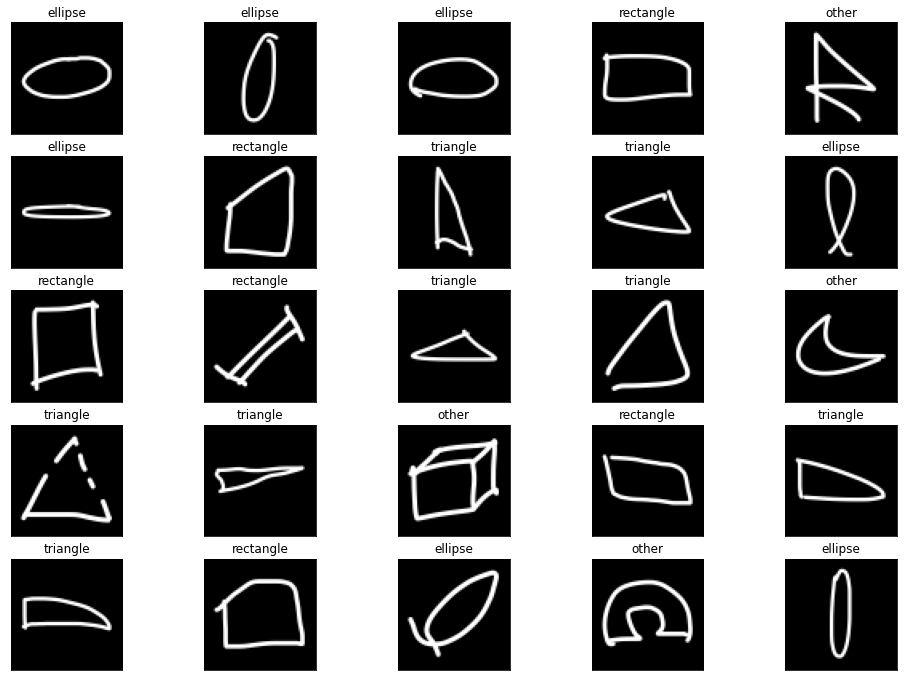

In [16]:
# Show 25 random images from the Train Set
indexes = np.arange(len(train_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_25_images(train_data[first_random_indexes],train_labels[first_random_indexes])

In [17]:
del train_data
del train_labels

In [18]:
# Validation data
val_user_images = []
val_user_images_label = []

for userDir in val_data_paths:
    load_images_for_user(userDir, pixel_depth, val_user_images, val_user_images_label)

val_data = np.array(val_user_images)
val_labels = np.array(val_user_images_label)

print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)
unique, counts = np.unique(val_labels, return_counts=True)
print("val label dist.: ", dict(zip(unique, counts)))

# Save validation data to single pickle file
save_to_pickle(
    VAL_DATAFILE,
    {
        'val_data': val_data,
        'val_labels': val_labels
    }
)

val_data shape:  (3983, 70, 70)
val_labels shape:  (3983,)
val label dist.:  {0: 1130, 1: 1069, 2: 860, 3: 924}


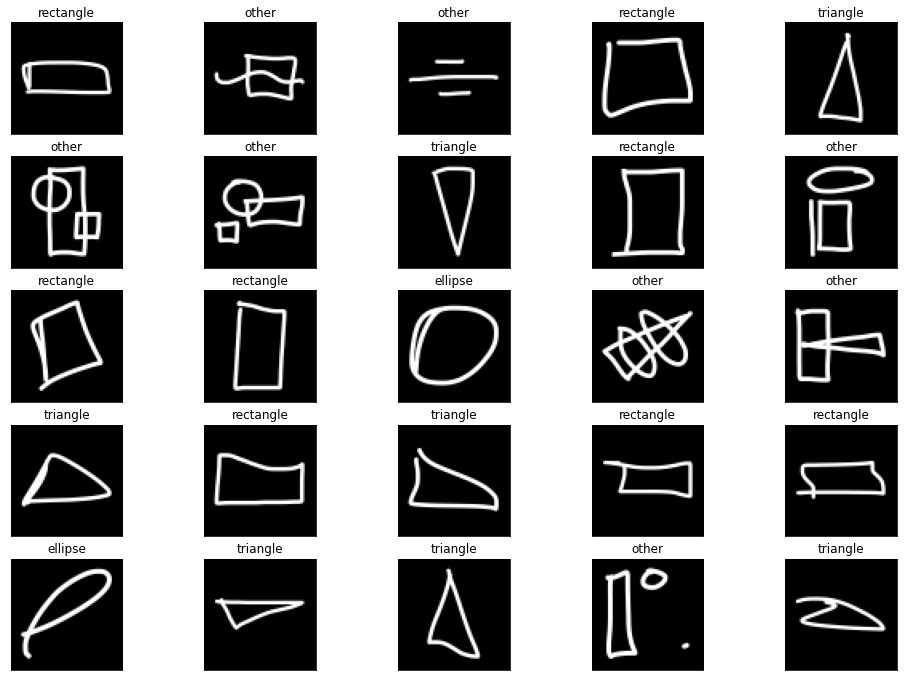

In [19]:
# Show 25 random images from the Validation Set
indexes = np.arange(len(val_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_25_images(val_data[first_random_indexes],val_labels[first_random_indexes])

In [20]:
del val_data
del val_labels

In [21]:
# Test data
test_user_images = []
test_user_images_label = []

for userDir in test_data_paths:
    load_images_for_user(userDir, pixel_depth, test_user_images, test_user_images_label)

test_data   = np.array(test_user_images)
test_labels = np.array(test_user_images_label)

print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)
unique, counts = np.unique(test_labels, return_counts=True)
print("test label dist.: ", dict(zip(unique, counts)))

# Save Test data to single pickle file
save_to_pickle(
    TEST_DATAFILE,
    {
        'test_data': test_data,
        'test_labels': test_labels
    }
)

test_data shape:  (1923, 70, 70)
test_labels shape:  (1923,)
test label dist.:  {0: 841, 1: 360, 2: 359, 3: 363}


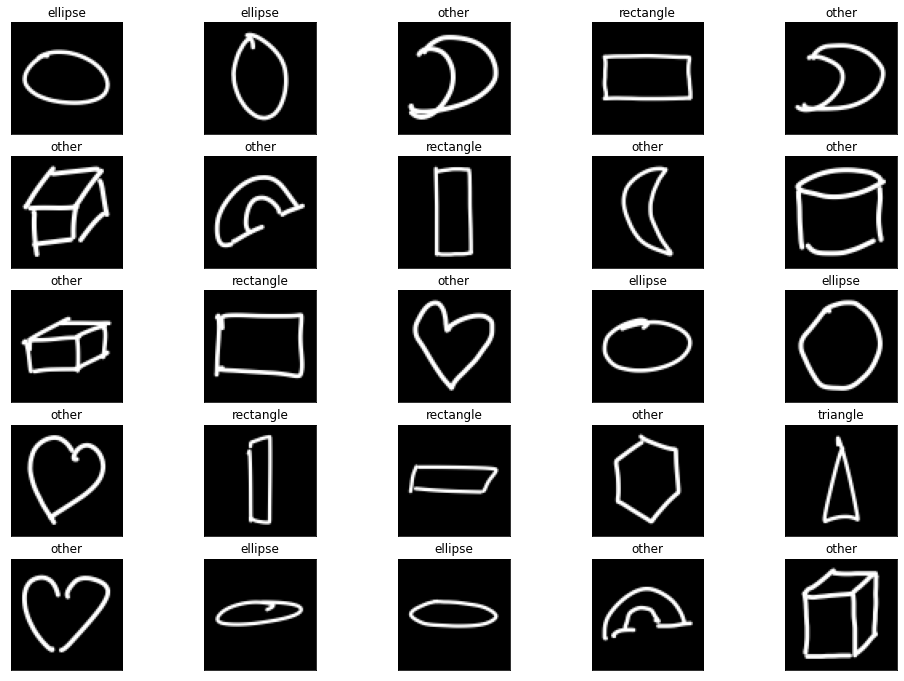

In [22]:
# Show 25 random images from the Test Set
indexes = np.arange(len(test_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_25_images(test_data[first_random_indexes], test_labels[first_random_indexes])

## ETL Completed